1. Check the inbound and outbound parameters of each station in the sum of the four quarters. Select the site with the largest amount of data for initial analysis.

In [4]:

import pandas as pd

# 1. Load data
# Read multiple CSV files for four quarters
quarters = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 
            'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df_list = [pd.read_csv(file) for file in quarters]
df = pd.concat(df_list, ignore_index=True)

# 2. Convert time columns to datetime format (optional but recommended)
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# 3. Calculate outbound trips per station
outbound_counts = df.groupby('from_station_id').size().reset_index(name='outbound_trips')

# 4. Calculate inbound trips per station
inbound_counts = df.groupby('to_station_id').size().reset_index(name='inbound_trips')

# 5. Merge inbound and outbound counts
station_counts = pd.merge(outbound_counts, inbound_counts, left_on='from_station_id', right_on='to_station_id', how='outer')

# 6. Fill NaN values with 0 (stations that only have inbound or outbound trips)
station_counts['outbound_trips'] = station_counts['outbound_trips'].fillna(0).astype(int)
station_counts['inbound_trips'] = station_counts['inbound_trips'].fillna(0).astype(int)
station_counts['difference_trips'] = (station_counts['outbound_trips'] - station_counts['inbound_trips']).abs()

# 7. Create a unified station_id column
station_counts['station_id'] = station_counts['from_station_id'].combine_first(station_counts['to_station_id'])

# 8. Select relevant columns
station_counts = station_counts[['station_id', 'outbound_trips', 'inbound_trips','difference_trips']]

# 9. Sort by station_id (optional)
station_counts = station_counts.sort_values(by='station_id').reset_index(drop=True)

outbound = station_counts.sort_values(by='outbound_trips').reset_index(drop=True)

inbound = station_counts.sort_values(by='inbound_trips').reset_index(drop=True)

difference = station_counts.sort_values(by='difference_trips').reset_index(drop=True)

# 10. Display the result
print(station_counts.head())
print(outbound.tail())
print(inbound.tail())
print(difference.tail())

# 11. Save to CSV file (optional)
station_counts.to_csv('station_trip_counts.csv', index=False)


   station_id  outbound_trips  inbound_trips  difference_trips
0         1.0               1              1                 0
1         2.0           11030           9283              1747
2         3.0           26432          22184              4248
3         4.0           10658          11042               384
4         5.0            7765           7615               150
     station_id  outbound_trips  inbound_trips  difference_trips
612        91.0           48153          50686              2533
613        76.0           49804          40633              9171
614        77.0           49908          47311              2597
615       192.0           54389          50127              4262
616        35.0           67983          81723             13740
     station_id  outbound_trips  inbound_trips  difference_trips
612       268.0           34472          42459              7987
613        77.0           49908          47311              2597
614       192.0           54389      

A time series analysis and ARIMA model forecast were performed for inbound and outbound demand at Site 195 in order to understand the change in demand over the coming week. This analysis can help identify peak demand and provide data to support operations and resource deployment

Outbound Demand Analysis and Forecast:
Station 195 Outbound Demand - ADF Statistic: -0.8372833945680116
Station 195 Outbound Demand - p-value: 0.8079243479152833
Station 195 Outbound Demand - Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1825.274
Date:                Thu, 07 Nov 2024   AIC                           3662.548
Time:                        15:33:12   BIC                           3685.931
Sample:                    01-01-2019   HQIC                          3671.842
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


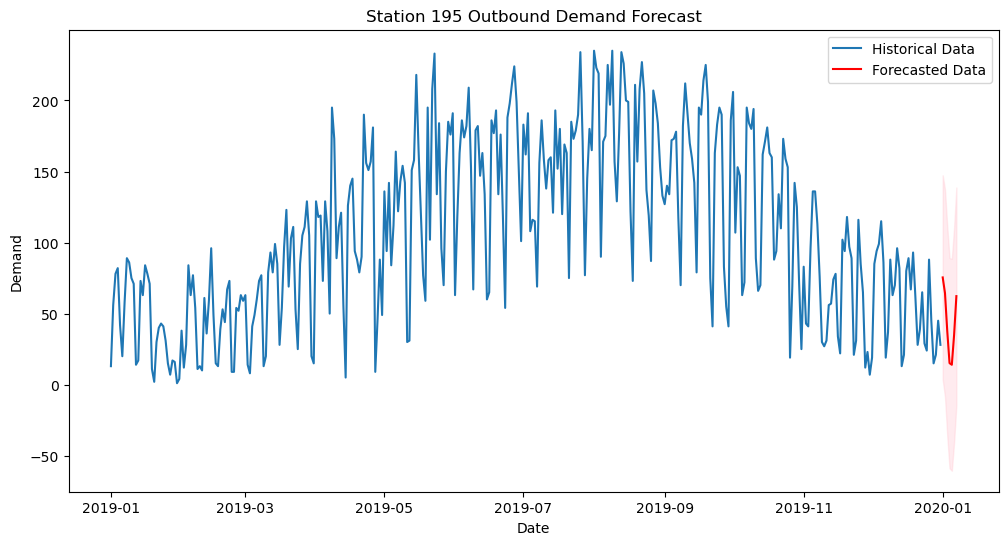

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Station 195 Outbound Demand - MAE: 71.10392803065805
Station 195 Outbound Demand - RMSE: 78.89299457327985
Inbound Demand Analysis and Forecast:
Station 195 Inbound Demand - ADF Statistic: -0.8147580127531336
Station 195 Inbound Demand - p-value: 0.8147485292569829
Station 195 Inbound Demand - Best ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -1629.446
Date:                Thu, 07 Nov 2024   AIC                           3278.892
Time:                        15:33:18   BIC                           3317.864
Sample:                    01-01-2019   HQIC                          3294.382
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z| 

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


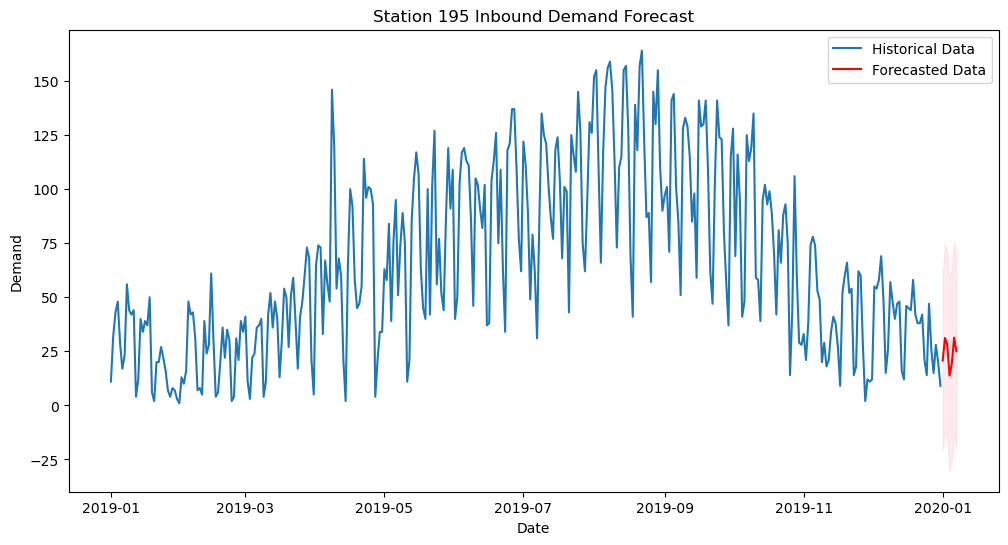

Station 195 Inbound Demand - MAE: 46.56985810294808
Station 195 Inbound Demand - RMSE: 51.93724319767903


/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


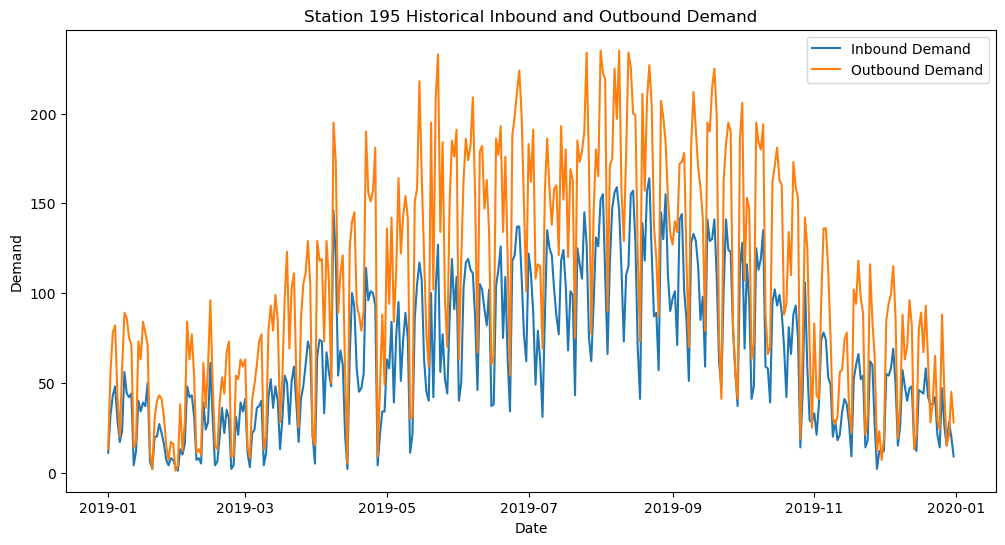

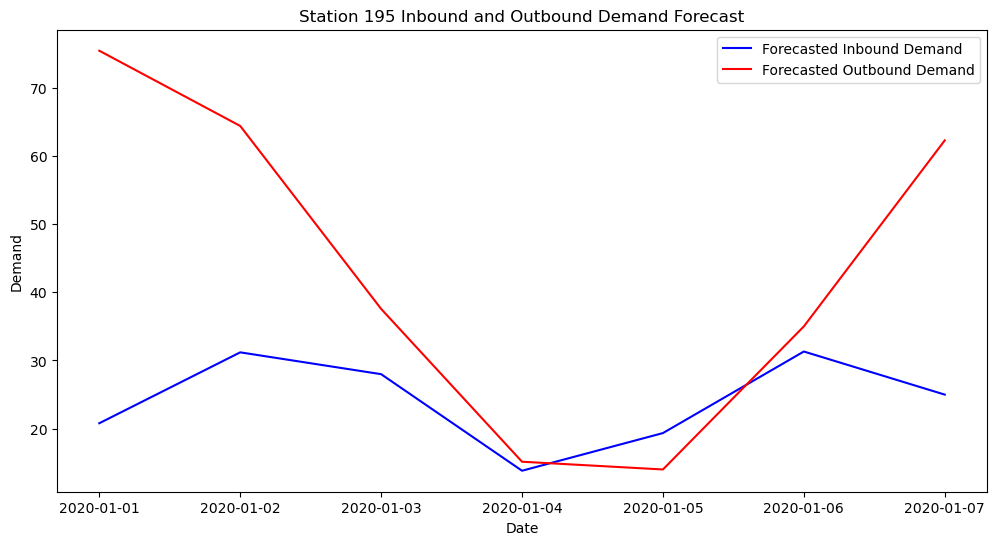

In [6]:

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Load data
# Read multiple CSV files for four quarters
quarters = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 
            'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df_list = [pd.read_csv(file) for file in quarters]
df = pd.concat(df_list, ignore_index=True)

# 2. Convert time format and extract dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

# Choose the station to analyze (e.g., station ID 195)
station_id = 195

# 3. Build outbound time series
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# 4. Build inbound time series
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()
inbound_series = inbound_data.asfreq('D', fill_value=0)

# 5. Define a function for time series analysis and forecasting
def analyze_and_forecast(time_series, title):
    # Check time series stationarity (ADF test)
    result = adfuller(time_series)
    print(f'{title} - ADF Statistic: {result[0]}')
    print(f'{title} - p-value: {result[1]}')
    # If p-value > 0.05, the series is non-stationary and differencing may be needed

    # Automatically select ARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=False, trace=False)
    print(f'{title} - Best ARIMA Model:')
    print(auto_arima_model.summary())

    # Fit ARIMA model
    order = auto_arima_model.order
    model = ARIMA(time_series, order=order)
    arima_result = model.fit()

    # Forecast future demand (e.g., next 7 days)
    forecast_steps = 7
    forecast = arima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Historical Data')
    plt.plot(forecast_series, label='Forecasted Data', color='red')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{title} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

    # Calculate error metrics
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]
    model_train = ARIMA(train, order=order).fit()
    pred_test = model_train.forecast(len(test))
    mae = mean_absolute_error(test, pred_test)
    rmse = np.sqrt(mean_squared_error(test, pred_test))
    print(f'{title} - MAE: {mae}')
    print(f'{title} - RMSE: {rmse}')

    return forecast_series

# 6. Analyze and forecast outbound demand
print('Outbound Demand Analysis and Forecast:')
forecast_outbound = analyze_and_forecast(outbound_series, f'Station {station_id} Outbound Demand')

# 7. Analyze and forecast inbound demand
print('Inbound Demand Analysis and Forecast:')
forecast_inbound = analyze_and_forecast(inbound_series, f'Station {station_id} Inbound Demand')

# 8. Visualize historical inbound and outbound data
plt.figure(figsize=(12, 6))
plt.plot(inbound_series.index, inbound_series, label='Inbound Demand')
plt.plot(outbound_series.index, outbound_series, label='Outbound Demand')
plt.title(f'Station {station_id} Historical Inbound and Outbound Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

# 9. Visualize forecasted inbound and outbound demand
plt.figure(figsize=(12, 6))
plt.plot(forecast_inbound.index, forecast_inbound, label='Forecasted Inbound Demand', color='blue')
plt.plot(forecast_outbound.index, forecast_outbound, label='Forecasted Outbound Demand', color='red')
plt.title(f'Station {station_id} Inbound and Outbound Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


2. seasonal=True and m=7 are introduced
Better fit and predict trends in demand by using seasonal ARIMA models. These improvements make the code better suited for handling demand data with longer time spans and periodic patterns.

Outbound Demand Analysis and Forecast:
Station 195 Outbound Demand - ADF Statistic: -0.8372833945680116
Station 195 Outbound Demand - p-value: 0.8079243479152833
Station 195 Outbound Demand - Best ARIMA Model:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -1773.744
Date:                           Thu, 07 Nov 2024   AIC                           3561.489
Time:                                   15:35:05   BIC                           3588.769
Sample:                               01-01-2019   HQIC                          3572.332
                                    - 12-31-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025    

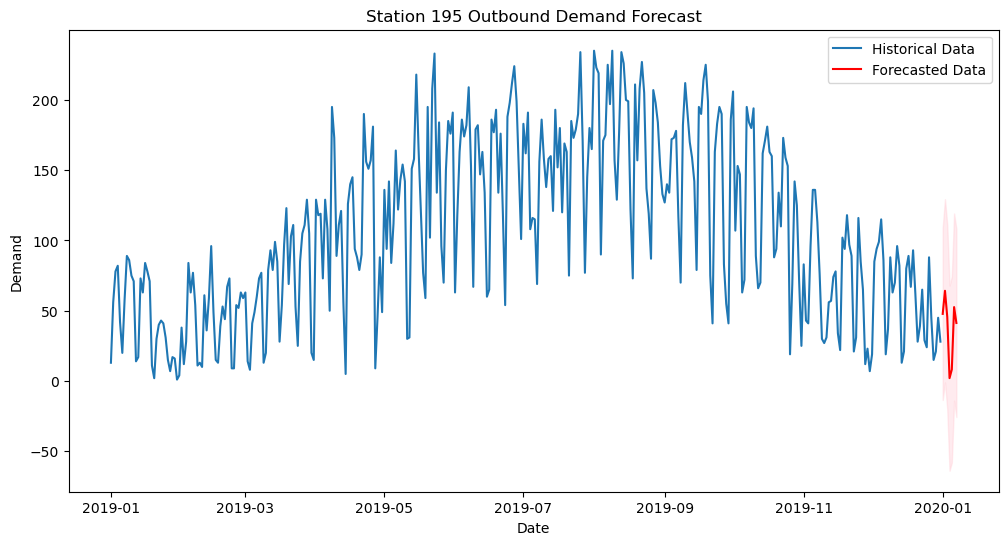

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Station 195 Outbound Demand - MAE: 56.74865777900437
Station 195 Outbound Demand - RMSE: 64.03832379325122
Inbound Demand Analysis and Forecast:
Station 195 Inbound Demand - ADF Statistic: -0.8147580127531336
Station 195 Inbound Demand - p-value: 0.8147485292569829
Station 195 Inbound Demand - Best ARIMA Model:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  365
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -1611.171
Date:                           Thu, 07 Nov 2024   AIC                           3236.343
Time:                                   15:35:27   BIC                           3263.623
Sample:                               01-01-2019   HQIC                          3247.185
                                    - 12-31-2019                                         
Covariance Type:                             opg         

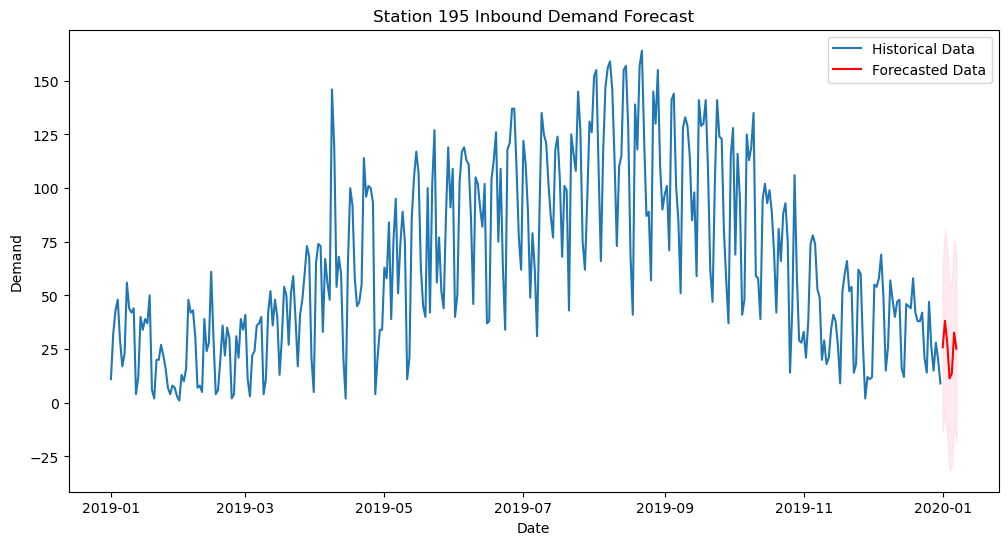

/Users/0x47/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Station 195 Inbound Demand - MAE: 35.97181713399648
Station 195 Inbound Demand - RMSE: 41.181353647160996


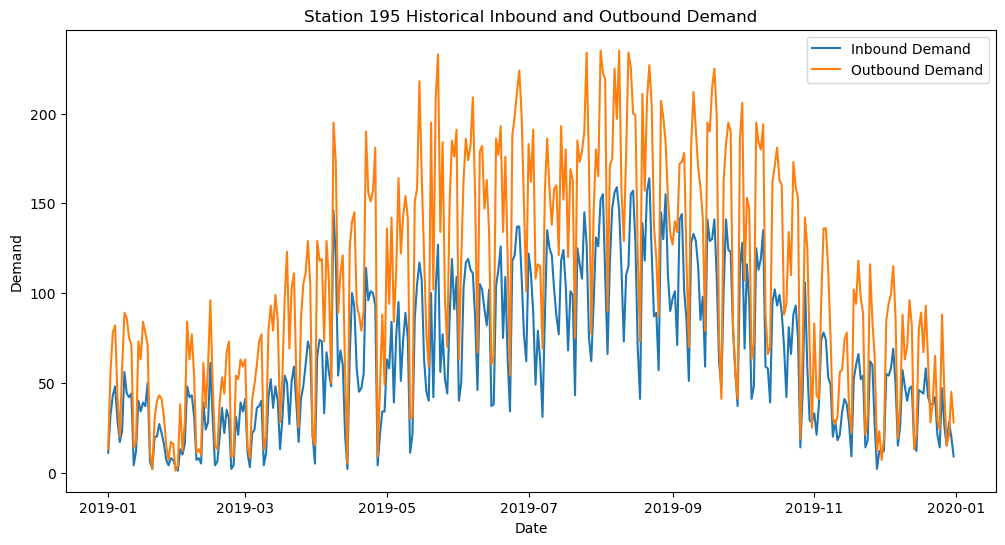

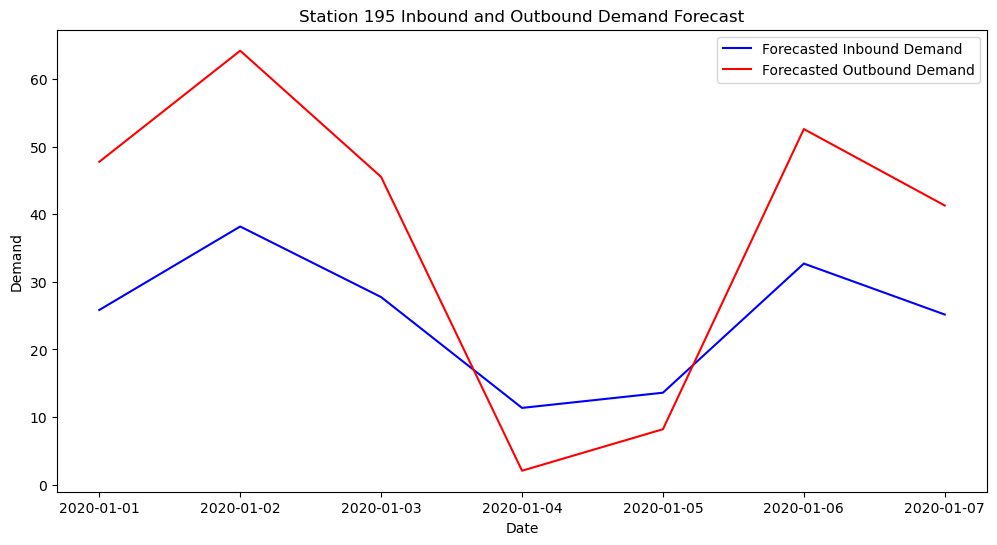

In [7]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Load data
# Read multiple CSV files for four quarters
quarters = ['Divvy_Trips_2019_Q1.csv', 'Divvy_Trips_2019_Q2.csv', 
            'Divvy_Trips_2019_Q3.csv', 'Divvy_Trips_2019_Q4.csv']
df_list = [pd.read_csv(file) for file in quarters]
df = pd.concat(df_list, ignore_index=True)

# 2. Convert time format and extract dates
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_date'] = df['start_time'].dt.date
df['end_date'] = df['end_time'].dt.date

# Choose the station to analyze (e.g., station ID 195)
station_id = 195

# 3. Build outbound time series
outbound_data = df[df['from_station_id'] == station_id].groupby('start_date').size()
outbound_series = outbound_data.asfreq('D', fill_value=0)

# 4. Build inbound time series
inbound_data = df[df['to_station_id'] == station_id].groupby('end_date').size()
inbound_series = inbound_data.asfreq('D', fill_value=0)

# 5. Define a function for time series analysis and forecasting
def analyze_and_forecast(time_series, title):
    # Check time series stationarity (ADF test)
    result = adfuller(time_series)
    print(f'{title} - ADF Statistic: {result[0]}')
    print(f'{title} - p-value: {result[1]}')
    # If p-value > 0.05, the series is non-stationary and differencing may be needed

    # Automatically select ARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=True, m=7, trace=False)  # Using seasonal=True and m=7 for weekly seasonality
    print(f'{title} - Best ARIMA Model:')
    print(auto_arima_model.summary())

    # Fit ARIMA model
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    model = ARIMA(time_series, order=order, seasonal_order=seasonal_order)
    arima_result = model.fit()

    # Forecast future demand (e.g., next 7 days)
    forecast_steps = 7
    forecast = arima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Historical Data')
    plt.plot(forecast_series, label='Forecasted Data', color='red')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{title} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

    # Calculate error metrics
    train_size = int(len(time_series) * 0.8)
    train, test = time_series[:train_size], time_series[train_size:]
    model_train = ARIMA(train, order=order, seasonal_order=seasonal_order).fit()
    pred_test = model_train.forecast(len(test))
    mae = mean_absolute_error(test, pred_test)
    rmse = np.sqrt(mean_squared_error(test, pred_test))
    print(f'{title} - MAE: {mae}')
    print(f'{title} - RMSE: {rmse}')

    return forecast_series

# 6. Analyze and forecast outbound demand
print('Outbound Demand Analysis and Forecast:')
forecast_outbound = analyze_and_forecast(outbound_series, f'Station {station_id} Outbound Demand')

# 7. Analyze and forecast inbound demand
print('Inbound Demand Analysis and Forecast:')
forecast_inbound = analyze_and_forecast(inbound_series, f'Station {station_id} Inbound Demand')

# 8. Visualize historical inbound and outbound data
plt.figure(figsize=(12, 6))
plt.plot(inbound_series.index, inbound_series, label='Inbound Demand')
plt.plot(outbound_series.index, outbound_series, label='Outbound Demand')
plt.title(f'Station {station_id} Historical Inbound and Outbound Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

# 9. Visualize forecasted inbound and outbound demand
plt.figure(figsize=(12, 6))
plt.plot(forecast_inbound.index, forecast_inbound, label='Forecasted Inbound Demand', color='blue')
plt.plot(forecast_outbound.index, forecast_outbound, label='Forecasted Outbound Demand', color='red')
plt.title(f'Station {station_id} Inbound and Outbound Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()


24h analyze

Single-Day Outbound Forecast:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=11592.281, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=10883.927, Time=0.87 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=10987.772, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=11590.281, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=11571.998, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=10860.948, Time=6.74 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=22.96 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=11029.696, Time=4.57 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=10791.693, Time=7.62 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=10815.343, Time=1.46 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=33.86 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.25 sec
 A

 This problem is unconstrained.



At iterate    5    f=  2.47360D+00    |proj g|=  7.72280D-03

At iterate   10    f=  2.47343D+00    |proj g|=  5.50440D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     10     12      1     0     0   5.504D-06   2.473D+00
  F =   2.4734291604679219     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


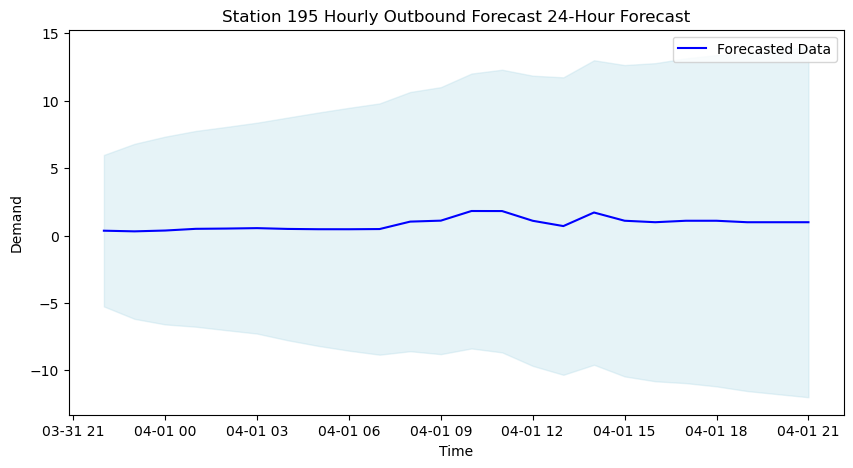

Single-Day Inbound Forecast:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=11.88 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=9857.573, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=9202.660, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=9110.269, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=9855.573, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=9714.322, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=6.64 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=8997.410, Time=8.00 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=24.77 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=9509.897, Time=4.51 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=inf, Time=34.77 sec
 ARIMA(0,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=22.70 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=9291.053, Time=5.82 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=33.02 sec
 ARIMA(0,1,1)(0

 This problem is unconstrained.



At iterate    5    f=  2.08678D+00    |proj g|=  2.04559D-02

At iterate   10    f=  2.08428D+00    |proj g|=  1.99727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   9.618D-06   2.084D+00
  F =   2.0842786814468606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


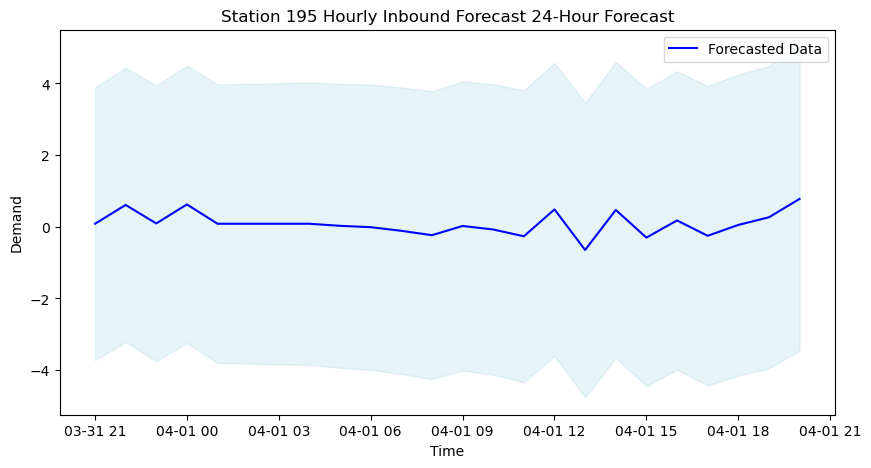

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_csv('Divvy_Trips_2019_Q1.csv')

# 2. Convert times to hourly timestamps
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_hour'] = df['start_time'].dt.floor('H')
df['end_hour'] = df['end_time'].dt.floor('H')

# 3. Select the station ID to analyze
station_id = 195  # Example station ID

# 4. Calculate hourly outbound and inbound counts
outbound_data = df[df['from_station_id'] == station_id].groupby('start_hour').size()
inbound_data = df[df['to_station_id'] == station_id].groupby('end_hour').size()

# Fill missing hourly data with 0 and set to hourly frequency
outbound_series = outbound_data.asfreq('H', fill_value=0)
inbound_series = inbound_data.asfreq('H', fill_value=0)

# 5. Analysis and forecasting function (modified for single-day forecast plot)
def forecast_single_day(time_series, title):
    # Automatically select SARIMA model parameters
    auto_arima_model = auto_arima(time_series, seasonal=True, m=24, trace=True)
    print(f'{title} Best SARIMA Model Parameters:', auto_arima_model.order, auto_arima_model.seasonal_order)

    # Fit SARIMA model
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    sarima_result = model.fit()

    # Forecast demand for the next 24 hours
    forecast_steps = 24
    forecast = sarima_result.get_forecast(steps=forecast_steps)
    forecast_index = pd.date_range(time_series.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

    # Plot only the forecasted data
    plt.figure(figsize=(10, 5))
    plt.plot(forecast_series, label='Forecasted Data', color='blue')
    plt.fill_between(forecast_series.index,
                     forecast.conf_int().iloc[:, 0],
                     forecast.conf_int().iloc[:, 1], color='lightblue', alpha=0.3)
    plt.title(f'{title} 24-Hour Forecast')
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.legend()
    plt.show()

# 6. Forecast single-day outbound count
print('Single-Day Outbound Forecast:')
forecast_single_day(outbound_series, f'Station {station_id} Hourly Outbound Forecast')

# 7. Forecast single-day inbound count
print('Single-Day Inbound Forecast:')
forecast_single_day(inbound_series, f'Station {station_id} Hourly Inbound Forecast')
